# Effect of perturbation around gene promoters

Here we test whether _in silico_ silencing of a gene leads to perturbation of chromatin profiles in proximity of the TSS. 

In [ ]:
# pip install bioframe

In [ ]:
# pip install pyjaspar

In [1]:
import os,sys
import multiDGD
import numpy as np
import pandas as pd
#import mudata as md
import anndata as ad
import bioframe
from pyjaspar import jaspardb
import genomic_features as gf

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms

####################################
# flexible parameters
####################################
figure_height = 7
n_cols = 1
n_rows = 1
grid_wspace = 1.5
grid_hspace = 2.5
figure_name = 'fig_template'

####################################
# fixed figure design
####################################
# set up figure and grid
cm = 1/2.54
fig = plt.figure(figsize=(18*cm,figure_height*cm))
gs = gridspec.GridSpec(n_rows,n_cols)
gs.update(wspace = grid_wspace, hspace = grid_hspace)
ax_list = []
# fonts
# general text
text_size = 8
scaling_factor = 3
plt.rcParams.update({'font.size': 4*scaling_factor, 'axes.linewidth': 0.3*scaling_factor,
                     'xtick.major.size': 1.5*scaling_factor, 'xtick.major.width': 0.3*scaling_factor, 'ytick.major.size': 1.5*scaling_factor, 'ytick.major.width': 0.3*scaling_factor})
# grid letters
grid_letter_positions = [-0.1, 0.05]
grid_letter_fontsize = 8
grid_letter_fontfamily = 'sans-serif'
grid_letter_fontweight = 'bold'
point_size = 1
# colors
palette_2colrs = ['palegoldenrod', 'cornflowerblue']
batch_palette = ['palegoldenrod', 'cornflowerblue', 'darkmagenta', 'darkslategray']
palette_3colrs = ["lightgray", "cornflowerblue", "darkmagenta", "darkolivegreen", "firebrick", "midnightblue"]
palette_continuous_1 = "GnBu"
palette_continuous_2 = 'magma_r'
# legend set up
legend_x_dist, legend_y_dist = -0.02, 0.0
handletextpad = 0.1
# scatter plot
point_size = 0.3
alpha = 1
point_linewidth = 0.0
handlesize = 0.5
# line plot
linewidth = 0.5

# set trans for labeling physical distance to the left and up:
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

<Figure size 708.661x275.591 with 0 Axes>

### Load trained model and data

In [3]:
model_dir = '/nfs/team205/ed6/data/bonemarrow_model/'

In [ ]:
# Read data
data = ad.read_h5ad(model_dir + 'GSE194122_openproblems_neurips2021_multiome_BMMC_processed_withDataSplit.h5ad')

In [69]:
# Load trained model
model = multiDGD.DGD.load(data=data, save_dir=model_dir, model_name='dgd_bonemarrow_default_trained_and_tested')

# specify the samples we want to look at
testset = data[data.obs["train_val_test"] == "test",:].copy()

Covariate model initialized as:

        Gaussian_mix_compture:
            Dimensionality: 2
            Number of components: 4
        
#######################
Training status
#######################
True


In [70]:
testset

AnnData object with n_obs × n_vars = 6925 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'train_val_test', 'observable', 'covariate_Site'
    var: 'feature_types', 'gene_id', 'modality'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'

### Get genomic ranges of peaks

In [ ]:
data = ad.read_h5ad(model_dir + 'GSE194122_openproblems_neurips2021_multiome_BMMC_processed_withDataSplit.h5ad', backed=True)

def _bioframe_from_strings(pos_list: pd.Series):
    """
    Function to create bioframe compatible table from string of genomic position
    """
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)
                      ).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)
                    ).str.split('-').str.get(1)

    # Create ranges
    bioframe_df = pd.concat([chr, start, end], axis=1)
    bioframe_df.columns = ['chrom', 'start', 'end']
    bioframe_df.loc[:,['start', 'end']] = bioframe_df.loc[:,['start', 'end']].astype(int)
    return bioframe_df.convert_dtypes()

# Get ranges of all peaks
pos_list = data.var[data.var['feature_types'] == 'ATAC'].index.tolist()
pos_list = pd.Series(pos_list).str.replace("-", ":", 1)
peaks_df = _bioframe_from_strings(pos_list)
peaks_df['name'] = '.'
peaks_df.columns = peaks_df.columns.astype('str')

peaks_df.to_csv(model_dir + 'GSE194122_openproblems_neurips2021_multiome_BMMC_processed_withDataSplit.peaks.csv')

## Save gene names
gene_names = data.var[data.var['feature_types'] == 'GEX']
gene_names.to_csv(model_dir + 'GSE194122_openproblems_neurips2021_multiome_BMMC_processed_withDataSplit.gene_names.csv')

In [25]:
peaks_df = pd.read_csv(model_dir + 'GSE194122_openproblems_neurips2021_multiome_BMMC_processed_withDataSplit.peaks.csv', index_col=0)
gene_names = pd.read_csv(model_dir + 'GSE194122_openproblems_neurips2021_multiome_BMMC_processed_withDataSplit.gene_names.csv', index_col=0) 

In [5]:
gene_names.index

Index(['AL627309.5', 'LINC01409', 'LINC01128', 'NOC2L', 'KLHL17', 'ISG15',
       'C1orf159', 'SDF4', 'B3GALT6', 'UBE2J2',
       ...
       'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6',
       'MT-CYB', 'AL592183.1', 'AC240274.1'],
      dtype='object', length=13431)

### Get genes to perturb 
Selection of highly variable genes

In [108]:
import scanpy as sc

gex_adata = testset[:,testset.var['feature_types'] == 'GEX'].copy()
sc.pp.normalize_total(gex_adata)
sc.pp.log1p(gex_adata)
sc.pp.highly_variable_genes(gex_adata)

In [127]:
promoter_genes_perturb = [x for x in gex_adata.var_names[gex_adata.var['highly_variable']].tolist() 
     if not x.endswith(".1") and not x.startswith("MT-") and not x.startswith("HIST")]

In [122]:
# Get positions of genes
ensdb = gf.ensembl.annotation(species="Hsapiens", version="108")
gene_ranges_df = ensdb.genes()
try:
    gene_ranges_df = gene_ranges_df[gene_ranges_df['gene_id'].isin(var_gex.gene_id)].copy()
    gene_ranges_df = gene_ranges_df.set_index("gene_id")
except KeyError:
    gene_ranges_df = gene_ranges_df.set_index("gene_name")

In [133]:
promoter_genes_perturb = [x for x in promoter_genes_perturb if x in gene_ranges_df.gene_name.tolist()]

In [135]:
with open('/nfs/team205/ed6/data/bonemarrow_model/genes_to_test.txt', 'w') as f:
    for g in promoter_genes_perturb:
        f.write(g + '\n')

### Run perturbation analysis

Using script `run_tss_analysis.py`

### Parse results

In [4]:
outfiles = [model_dir + x for x in os.listdir(model_dir) if x.startswith('TSS_perturb_experiment_with_ctrl')]
tss_res_df = pd.concat([pd.read_csv(f) for f in outfiles])

In [5]:
n_genes = tss_res_df.perturbed_gene.nunique()

In [6]:
n_genes

2073

In [252]:
true_tss_res_df = tss_res_df[tss_res_df.set == 'true'].sort_values('distance').drop_duplicates()
ctrl_tss_res_df = tss_res_df[tss_res_df.set == 'neg_control'].sort_values('distance').drop_duplicates()

In [253]:
def get_mean_signal(true_tss_res_df,  wi_size = 200):
    ixs_ls = []
    for x in np.arange(0,10000):
        ixs = np.where((true_tss_res_df['distance'] >= x) & (true_tss_res_df['distance'] < x+w_size))[0]
        ixs_ls.append(ixs)

    means_ls = []
    sds_ls = []
    for ixs in ixs_ls:
        means = true_tss_res_df.iloc[ixs]['mean_delta'].mean()
        means_ls.append(means)
        sds_ls.append(true_tss_res_df.iloc[ixs]['mean_delta'].sem())

    df = pd.DataFrame([np.array(means_ls), np.array(sds_ls), np.arange(0,10000)]).T
#     df.columns = ['mean_delta','sd_mean_delta', 'distance']
    return(df)

In [254]:
df_averaged = get_mean_signal(true_tss_res_df)
df_ctrl_averaged = get_mean_signal(ctrl_tss_res_df)

In [255]:
df_averaged.columns = ['mean_delta','sd_mean_delta', 'distance']
df_ctrl_averaged.columns = ['mean_delta','sd_mean_delta', 'distance']

Main figure

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


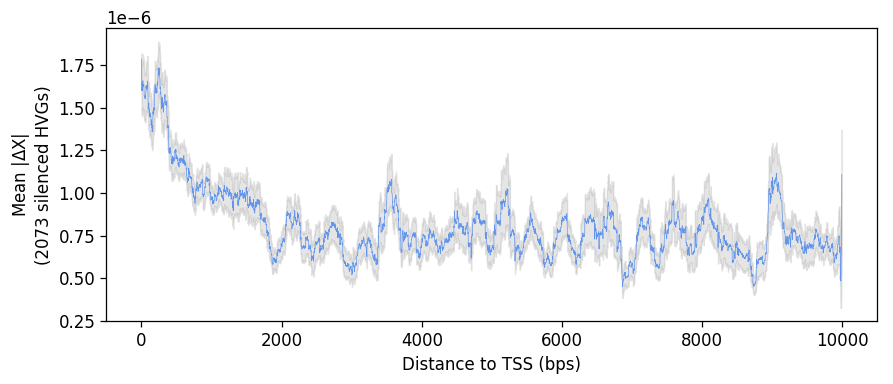

In [261]:
plt.rcParams['figure.figsize'] = [9,4]
sns.lineplot(data=df_averaged, x='distance', y='mean_delta', color=palette_2colrs[1], linewidth=0.5)
plt.fill_between(df_averaged['distance'], df_averaged['mean_delta'] - df_averaged['sd_mean_delta'], df_averaged['mean_delta'] + df_averaged['sd_mean_delta'], alpha=0.2, color='grey')
plt.legend(bbox_to_anchor=(1.+legend_x_dist, 1.+legend_y_dist), 
                   loc='upper left', frameon=False,
                   handletextpad=handletextpad);
plt.xlabel("Distance to TSS (bps)");
# plt.text(8000, 1.6e-6, s=f'{n_genes} HVGs');
plt.ylabel("Mean |$\Delta$X|\n({n_genes} silenced HVGs)".format(n_genes = n_genes));
plt.tight_layout()
plt.savefig("/home/jovyan/mount/gdrive/DGD_multiomics/plot_outputs/TSS_signal.pdf");

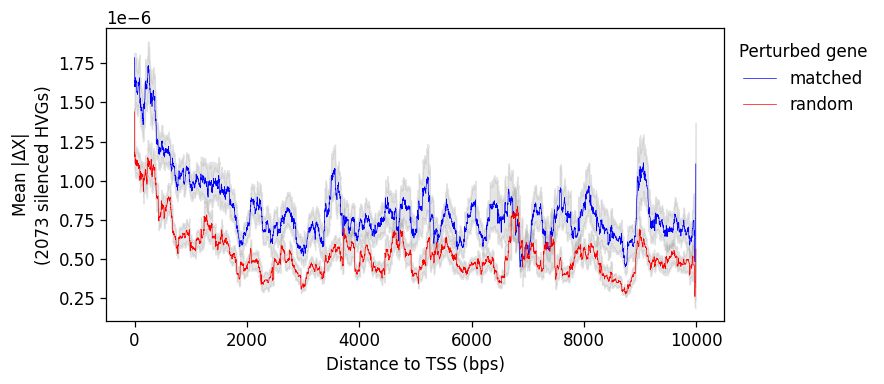

In [281]:
sns.lineplot(data=df_averaged, x='distance', y='mean_delta', color='blue', linewidth=0.5, label='matched')
plt.fill_between(df_averaged['distance'], df_averaged['mean_delta'] - df_averaged['sd_mean_delta'], df_averaged['mean_delta'] + df_averaged['sd_mean_delta'], alpha=0.2, color='grey')
sns.lineplot(data=df_ctrl_averaged, x='distance', y='mean_delta', color='red', linewidth=0.5, label='random')
plt.fill_between(df_ctrl_averaged['distance'], df_ctrl_averaged['mean_delta'] - df_ctrl_averaged['sd_mean_delta'], df_ctrl_averaged['mean_delta'] + df_ctrl_averaged['sd_mean_delta'], alpha=0.2, color='grey')
plt.xlabel("Distance to TSS (bps)");
plt.ylabel("Mean |$\Delta$X|\n({n_genes} silenced HVGs)".format(n_genes = n_genes));
plt.legend(bbox_to_anchor=(1., 1.), loc='upper left', frameon=False, title='Perturbed gene');
plt.tight_layout();
plt.savefig("/home/jovyan/mount/gdrive/DGD_multiomics/plot_outputs/TSS_signal_wControls.pdf");

In [282]:
ngs = tss_res_df[['perturbed_gene', 'set']].drop_duplicates().groupby('perturbed_gene').size().sort_values()
genes_to_test = ngs[ngs == 2].index

In [269]:

# with plt.rc_context({'figure.figsize':[18,10]}):
#     for i,gene in enumerate(genes_to_test):
#         if i < len(genes_to_test) - 1:
#             plt.subplot(4,5,i+1)
#             sns.scatterplot(data=tss_res_df[tss_res_df.perturbed_gene == gene], x='distance', y='mean_delta', hue='set', palette={'neg_control':'red','true':'blue'})
#             plt.ylabel("Mean |$\Delta$X|")
#             plt.title(gene)
#             plt.legend().remove()  # Remove legend for all subplots except the last one
#         else:
#             ax = plt.subplot(4,5,i+1)
#             sns.scatterplot(data=tss_res_df[tss_res_df.perturbed_gene == gene], x='distance', y='mean_delta', hue='set', palette={'neg_control':'red','true':'blue'})
#             plt.ylabel("Mean |$\Delta$X|")
#             plt.title(gene)
#             plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Display legend outside for the last subplot

#     plt.tight_layout()


In [283]:
genes_to_test = ngs[ngs == 2].index
true_tss_df = tss_res_df[tss_res_df.perturbed_gene.isin(genes_to_test) & (tss_res_df.distance == 0)]
true_tss_df = true_tss_df.drop_duplicates().groupby(['perturbed_gene', 'set'])['mean_delta'].mean().reset_index()

In [284]:
import scipy.stats as stats

# Paired t-test between matched and random perturbation
test_df = true_tss_df.pivot(index='perturbed_gene', columns='set', values='mean_delta')
ttest_pval = stats.ttest_rel(test_df['neg_control'], test_df['true']).pvalue

sorted_genes = test_df.sort_values('neg_control').index.tolist()
true_tss_df['perturbed_gene'] = true_tss_df['perturbed_gene'].astype('category').cat.reorder_categories(sorted_genes)

true_tss_df['Perturbed gene'] = np.where(true_tss_df['set'] == 'true', 'matched', 'random')

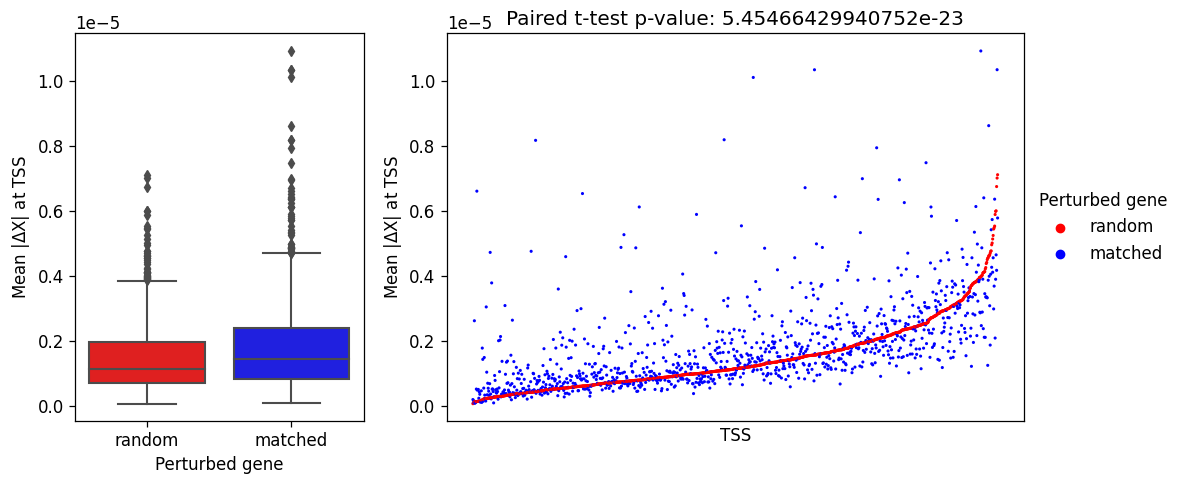

In [285]:
import matplotlib.gridspec as gridspec

# Create a figure and gridspec with 1 row and 2 columns, with width ratios of 1:2
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

# First subplot with half the width
ax1 = fig.add_subplot(gs[0])
sns.boxplot(data=true_tss_df.sort_values(['perturbed_gene', 'set']).drop_duplicates(),
            x='Perturbed gene', y='mean_delta', palette={'random':'red','matched':'blue'}, ax=ax1)
ax1.set_ylabel("Mean |$\Delta$X| at TSS")

# Second subplot with double the width
ax2 = fig.add_subplot(gs[1])
sns.scatterplot(data=true_tss_df.sort_values(['perturbed_gene']),
                x='perturbed_gene', y='mean_delta', palette={'random':'red','matched':'blue'}, hue='Perturbed gene', s=5, edgecolor='none', ax=ax2)
ax2.set_xticks([])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Perturbed gene')
ax2.set_ylabel("Mean |$\Delta$X| at TSS")
ax2.set_xlabel("TSS")
ax2.set_title(f'Paired t-test p-value: {ttest_pval}')

plt.tight_layout()
plt.savefig("/home/jovyan/mount/gdrive/DGD_multiomics/plot_outputs/TSS_signal_wControls_distance0.pdf");
